# Example notebook for 2-class e/gamma analysis
Originally from: https://github.com/nickwp/watchmal-examples/blob/master/IWCD%20PID%20example%20analysis%20of%20single%20ResNet%20run.ipynb

This notebook contains an example analysis of WatChMaL classification runs.
- The gamma events were generated using the gamma-conversion generator: https://github.com/nickwp/WCSim/tree/nuPRISM/GammaConversions 
- Timing information was added to WatChMaL by A. De Lorenzis: https://github.com/adelorenzis/WatChMaL

Plots are included of the training progression, ROC curves, and various plots of signal or background efficiency vs physical quantities.

In [2]:
# install some additional packages (may need to restart runtime after running this)
!pip install omegaconf uproot hydra-core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.4/331.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.3/600.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.3 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=6ec268bf28e24d81f7cfaa1f3d791f4d858cad2240ad28484f29f974f5be4995
  Stored in directory: /root/.cache/pip/wheels/23/cf/80/f3efa822e6ab23277902ee9165fe772eeb1dfb8014f359020a
Successfully built antlr4-python3-runtime


## Imports and setup

First change some display settings for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

External imports:

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import tabulate
import pandas as pd

Import WatChMaL analysis code

In [5]:
!git clone https://github.com/nickwp/WatChMaL.git
!cd WatChMaL && git checkout analysis_cleanup

Cloning into 'WatChMaL'...
remote: Enumerating objects: 3197, done.
remote: Counting objects: 100% (3197/3197), done.
remote: Compressing objects: 100% (1285/1285), done.
remote: Total 3197 (delta 1779), reused 3092 (delta 1735), pack-reused 0
Receiving objects: 100% (3197/3197), 986.31 KiB | 3.39 MiB/s, done.
Resolving deltas: 100% (1779/1779), done.
Branch 'analysis_cleanup' set up to track remote branch 'analysis_cleanup' from 'origin'.
Switched to a new branch 'analysis_cleanup'


In [4]:
# either add WatChMaL repository directory to PYTHONPATH environment variable or add it here
sys.path.append('WatChMaL')

In [5]:
import analysis.utils.math as math
from analysis.utils.binning import get_binning, apply_binning
from analysis.utils.plotting import plot_legend
from analysis.classification import WatChMaLClassification, FiTQunClassification, plot_rocs, plot_efficiency_profile, combine_softmax
from analysis.read import FiTQunOutput
#from watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset import CNNmPMTDataset

Imported analysis code from WatChMaL repository with git version: fd9a1db


# Preparing data

## Download the data

In [8]:
# Get the main HDF5 dataset and indices file.
!wget -O mu_e_gammac.h5 "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EUUHR15bXrRJknoQTbh5ieUBC0q0IVCazHwAJTRtwRSiVw?e=we7zcZ&download=1"
!wget -O e_gammac_idxs.npz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EbO1qG1T0NRBkVaoYqTohdYBuDCwXF-8uQB_i9ltWTgA0A?e=uirOcM&download=1"

# Get the WatChMaL output files and un-tar them.
!wget -O watchmal_output_gammaconv.tar.gz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/Ec0jhiwHejVCvUt_nvoL8QwB79MUHw-cW92bTmCY3rmmiw?e=XV92oy&download=1"
!tar -xvf watchmal_output_gammaconv.tar.gz
!wget -O watchmal_output_gammaconv_time.tar.gz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EaUOgmXJKvdIjVC24SD2uGMBaO0OseIXGC8ZQwHhOqb01A?e=CGkctS&download=1"
!tar -xvf watchmal_output_gammaconv_time.tar.gz
!wget -O watchmal_output_gammaconv_time_2class.tar.gz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/ER5ZhaPnJoVJk0kW2ETabhUBmV8DBwCKnhBjANIwkKU6Qg?e=qtoRvs&download=1"
!tar -xvf watchmal_output_gammaconv_time_2class.tar.gz
!wget -O iwcd_results.tar.gz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EdO9E18SKEtJqUNQZmmHZ7cBJdgZhTLg2lh4oct9vehClA?e=tLepfZ&download=1"
!tar -xvf iwcd_results.tar.gz

# Get the mPMT positions file.
!wget -O NuPRISMBeamTest_16cShort_mPMT_positions.npz "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EZq_pq6tOGFAguap2kMZZW8BRz1BiM2AijB97zAhexncwQ&download=1"

--2023-04-18 09:45:40--  https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EUUHR15bXrRJknoQTbh5ieUBC0q0IVCazHwAJTRtwRSiVw?e=we7zcZ&download=1
Resolving nubeusc-my.sharepoint.com (nubeusc-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to nubeusc-my.sharepoint.com (nubeusc-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jedward_renner_usc_es/Documents/wcte/sim/mu_e_gammac.h5?ga=1 [following]
--2023-04-18 09:45:42--  https://nubeusc-my.sharepoint.com/personal/jedward_renner_usc_es/Documents/wcte/sim/mu_e_gammac.h5?ga=1
Reusing existing connection to nubeusc-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1944015364 (1.8G) [application/octet-stream]
Saving to: ‘mu_e_gammac.h5’

mu_e_gammac.h5      100%[===================>]   1.81G  30.1MB/s    in 56s     

2023-04-18 09:46:39 (33.0 MB/s) - ‘mu_e_gammac.h5’ saved [1944015364/19440153

In [44]:
!wget -O e_gamma_mu_pi.h5 "https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EbrkCDDu94tGkiXgfd4Hb28BdXvUvKR6b2tYbeOlzL4Z3A?e=8ZqzeT&download=1"

--2023-04-18 10:38:35--  https://nubeusc-my.sharepoint.com/:u:/g/personal/jedward_renner_usc_es/EbrkCDDu94tGkiXgfd4Hb28BdXvUvKR6b2tYbeOlzL4Z3A?e=8ZqzeT&download=1
Resolving nubeusc-my.sharepoint.com (nubeusc-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to nubeusc-my.sharepoint.com (nubeusc-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jedward_renner_usc_es/Documents/wcte/e_gamma_mu_pi_100k/gamma_e_mu_pi.h5?ga=1 [following]
--2023-04-18 10:38:37--  https://nubeusc-my.sharepoint.com/personal/jedward_renner_usc_es/Documents/wcte/e_gamma_mu_pi_100k/gamma_e_mu_pi.h5?ga=1
Reusing existing connection to nubeusc-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2844622000 (2.6G) [application/octet-stream]
Saving to: ‘e_gamma_mu_pi.h5’

e_gamma_mu_pi.h5    100%[===================>]   2.65G  36.0MB/s    in 69s     

2023-04-18 10:39:46 (39.4 MB/s) - ‘e_gamm

## Get true particle data from h5 file

In [45]:
# list of particle names to use in filename
#particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3
particle_names = ['gamma', 'e-'] # note that the order corresponds to labels 0, 1

In [46]:
# get indices of test events
idxs_path = 'e_gammac_idxs.npz'
idxs_file  = np.load(idxs_path)
train_idxs = idxs_file['train_idxs']
val_idxs = idxs_file['val_idxs']
test_idxs  = idxs_file['test_idxs']

idxs_iwcd_4class_path = 'IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs_iwcd_4class_file = np.load(idxs_iwcd_4class_path)
test_iwcd_4class_idxs = idxs_iwcd_4class_file['test_idxs']
test_iwcd_4class_labels = np.load('iwcd_test_labels_4class.npz')['h5_labels']

idxs_iwcd_2class_path = 'IWCD_mPMT_Short_2_class_eg_9M_idxs.npz'
idxs_iwcd_2class_file = np.load(idxs_iwcd_2class_path)
test_iwcd_2class_idxs = idxs_iwcd_2class_file['test_idxs']
test_iwcd_2class_labels = np.load('iwcd_test_labels_2class.npz')['h5_labels']

### Open H5 data

In [47]:
# open h5 file and get data for test events
data_path = "e_gamma_mu_pi.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_hits_start = events_hits_index[test_idxs].squeeze()
h5_hits_end   = events_hits_index[test_idxs+1].squeeze()
h5_nhits      = h5_hits_end - h5_hits_start

In [48]:
# Create the hits dataframe

# Get charge and timing information for all events.
h5_all_hit_charge = np.array(h5_file['hit_charge'])
h5_all_hit_time   = np.array(h5_file['hit_time'])
h5_all_hit_pmt    = np.array(h5_file['hit_pmt'])

# Set the event ID, particle ID, and event type.
nhits = len(h5_all_hit_pmt)
l_charge, l_time, l_pmtid, l_eventid, l_label = [],[],[],[],[]
for id,nh,label,istart,iend in zip(h5_event_ids,h5_nhits,h5_labels,h5_hits_start,h5_hits_end):

  subarr_charge  = h5_all_hit_charge[istart:iend]
  subarr_time    = h5_all_hit_time[istart:iend]
  subarr_pmtid   = h5_all_hit_pmt[istart:iend]
  subarr_eventid = np.ones(nh)*id
  subarr_label   = np.ones(nh)*label

  #print("Event",id,"with hits",nh,"start",istart,"and end",iend)
  l_charge.append(subarr_charge)
  l_time.append(subarr_time)
  l_pmtid.append(subarr_pmtid)
  l_eventid.append(subarr_eventid)
  l_label.append(subarr_label)

dict_hits = {'charge':  np.array([chg for sublist in l_charge for chg in sublist]),
             'time':    np.array([time for sublist in l_time for time in sublist]),
             'pmtid':   np.array([pmtid for sublist in l_pmtid for pmtid in sublist]),
             'eventid': np.array([id for sublist in l_eventid for id in sublist]),
             'label':   np.array([label for sublist in l_label for label in sublist])}

df_hits = pd.DataFrame.from_dict(dict_hits)

In [10]:
h5_directions = math.direction_from_angles(h5_angles)

# Plotting ResNet performance

## Set up plotting style

In [11]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12, 9)
matplotlib.rcParams["figure.autolayout"] = True

## Make some cuts to select the events of interest

In [12]:
help(math.towall)

Help on function towall in module analysis.utils.math:

towall(position, angle, tank_half_height=300, tank_radius=400, tank_axis=None)
    Calculate towall: distance from position to detector wall, in particle direction
    
    Parameters
    ----------
    position : array_like
        vector of (x, y, z) position of a particle or (N,3) array of positions for N particles
    angle : array_like
        vector of (zenith, azimuth) direction of particle or (N, 2) array of directions for N particles
    tank_half_height : float, default: 300
        half-height of the detector ID
    tank_radius : float, default: 400
        Radius of the detector ID
    tank_axis : int, optional
        Axis along which the tank cylinder is oriented. By default, use the y-axis.
    
    Returns
    -------
    np.ndarray or scalar
        array of towall values for each position, or scalar if only one position



In [13]:
h5_towall = math.towall(h5_positions, h5_angles, tank_half_height=136.95, tank_radius=172.05)
h5_dwall = math.dwall(h5_positions, tank_half_height=136.95, tank_radius=172.05)
h5_momentum = math.momentum_from_energy(h5_energies, h5_labels)

od_veto_cut = (h5_vetos == 0)
dwall_cut = h5_dwall > -1000
towall_cut = (h5_towall > -1000) & (h5_towall < 1000)
nhits_cut = h5_nhits > 30

h5_gammas = (h5_labels == 0)
h5_electrons = (h5_labels == 1)

# select the true electron and muon events that pass the cuts
cuts = (h5_electrons | h5_gammas)

### xyz (launch vertex)

Text(0.5, 0, 'z (cm)')

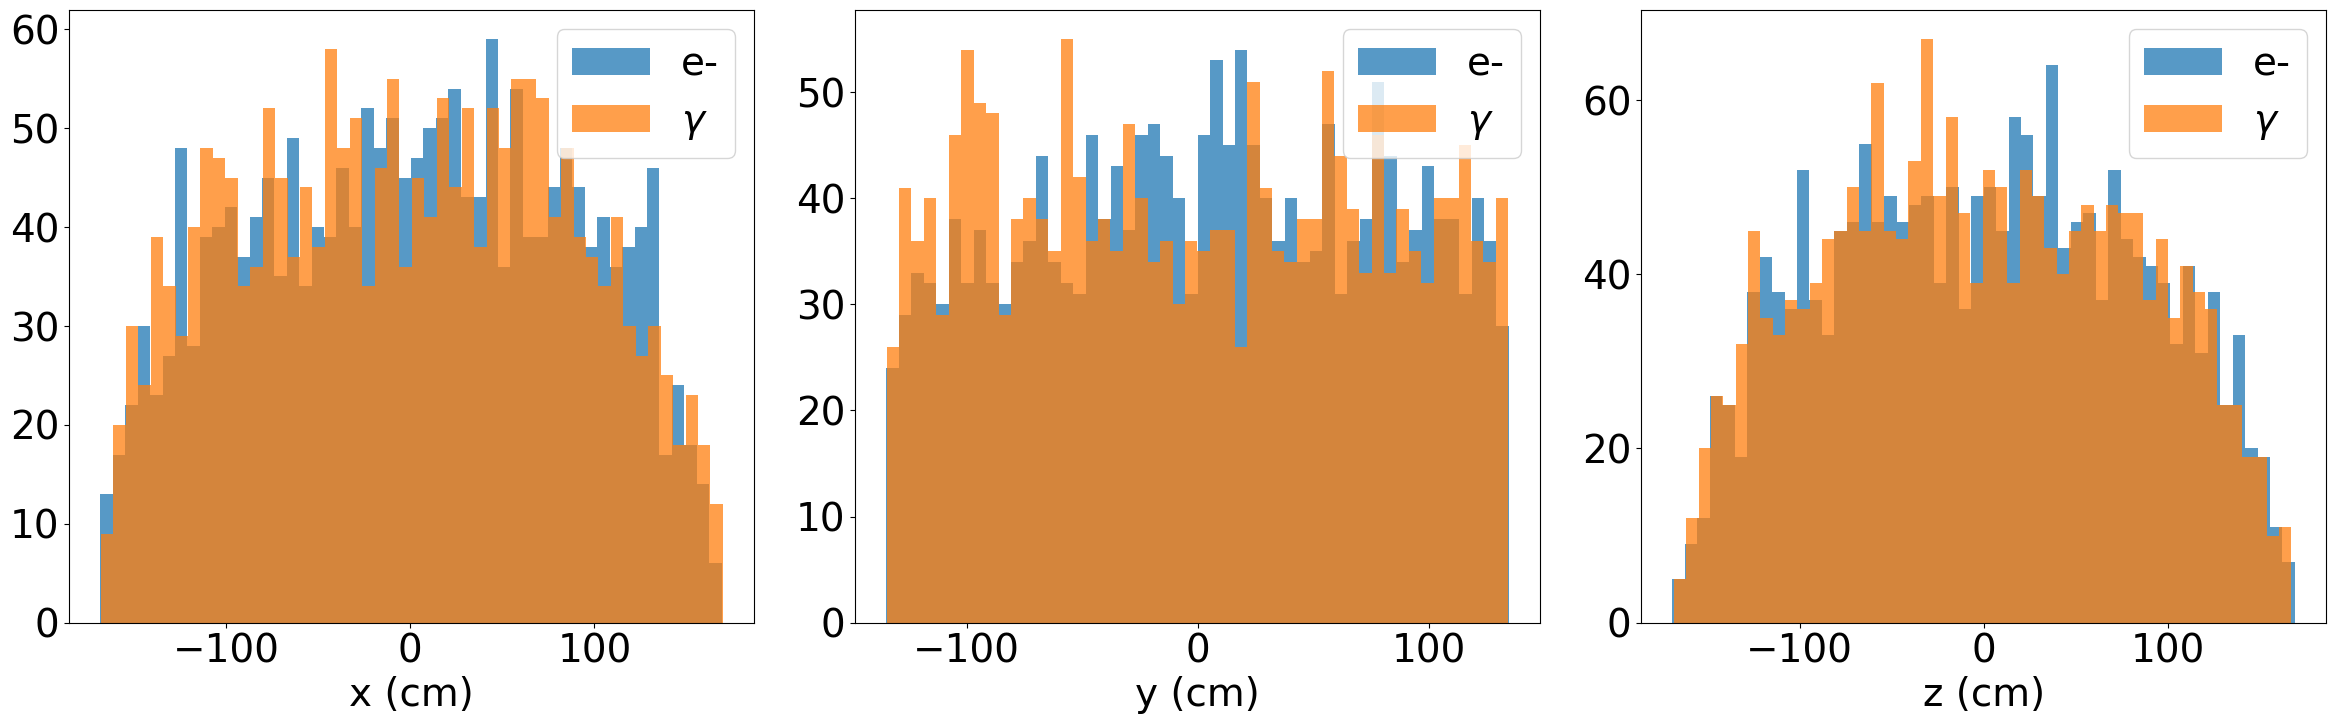

In [14]:
xpos_elec = h5_positions[h5_electrons][:,0]
ypos_elec = h5_positions[h5_electrons][:,1]
zpos_elec = h5_positions[h5_electrons][:,2]

xpos_gamma = h5_positions[h5_gammas][:,0]
ypos_gamma = h5_positions[h5_gammas][:,1]
zpos_gamma = h5_positions[h5_gammas][:,2]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(131)
ax1.hist(xpos_elec,bins=50,label='e-',alpha=0.75)
ax1.hist(xpos_gamma,bins=50,label='$\gamma$',alpha=0.75)
ax1.legend()
ax1.set_xlabel("x (cm)")
ax2 = fig.add_subplot(132)
ax2.hist(ypos_elec,bins=50,label='e-',alpha=0.75)
ax2.hist(ypos_gamma,bins=50,label='$\gamma$',alpha=0.75)
ax2.legend()
ax2.set_xlabel("y (cm)")
ax3 = fig.add_subplot(133)
ax3.hist(zpos_elec,bins=50,label='e-',alpha=0.75)
ax3.hist(zpos_gamma,bins=50,label='$\gamma$',alpha=0.75)
ax3.legend()
ax3.set_xlabel("z (cm)")

Text(0, 0.5, 'nhits')

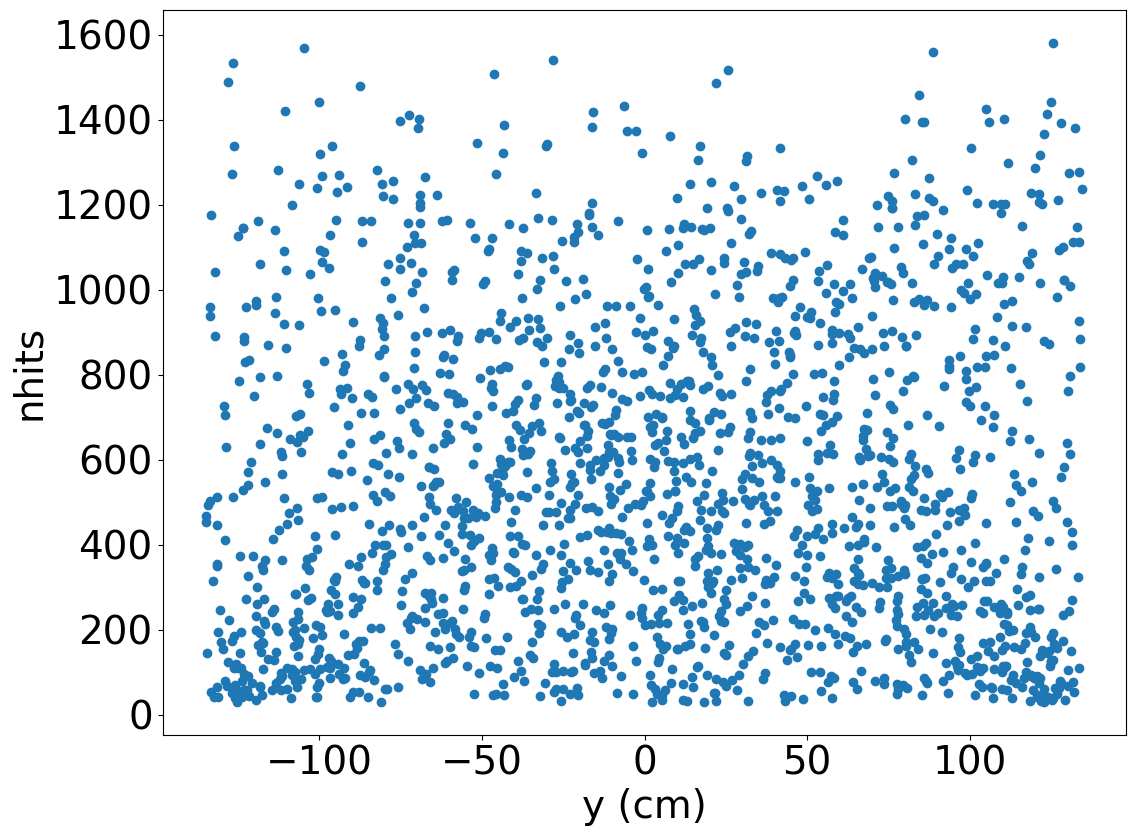

In [15]:
plt.scatter(ypos_elec,h5_nhits[h5_electrons])
plt.xlabel("y (cm)")
plt.ylabel("nhits")

### xyz direction

Text(0.5, 0, 'dir-z')

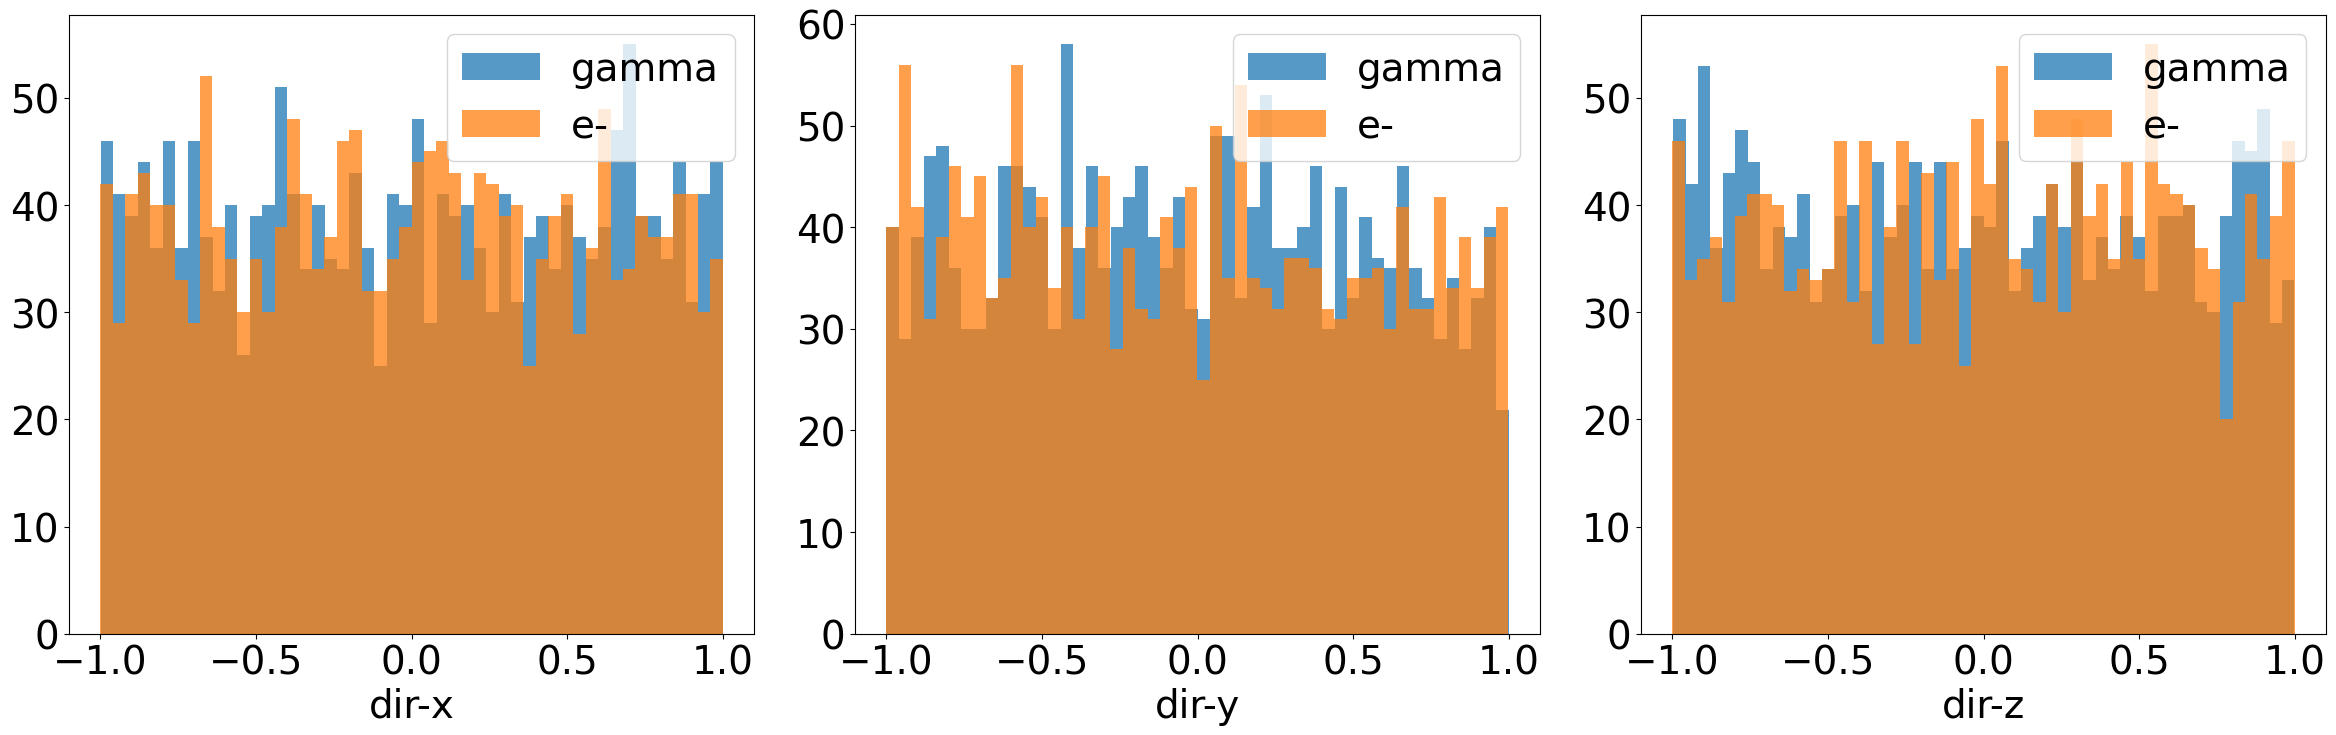

In [16]:
xdir_gamma = h5_directions[h5_gammas][:,0]
ydir_gamma = h5_directions[h5_gammas][:,1]
zdir_gamma = h5_directions[h5_gammas][:,2]

xdir_elec = h5_directions[h5_electrons][:,0]
ydir_elec = h5_directions[h5_electrons][:,1]
zdir_elec = h5_directions[h5_electrons][:,2]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(131)
ax1.hist(xdir_gamma,bins=50,label='gamma',alpha=0.75)
ax1.hist(xdir_elec,bins=50,label='e-',alpha=0.75)
ax1.legend()
ax1.set_xlabel("dir-x")
ax2 = fig.add_subplot(132)
ax2.hist(ydir_gamma,bins=50,label='gamma',alpha=0.75)
ax2.hist(ydir_elec,bins=50,label='e-',alpha=0.75)
ax2.legend()
ax2.set_xlabel("dir-y")
ax3 = fig.add_subplot(133)
ax3.hist(zdir_gamma,bins=50,label='gamma',alpha=0.75)
ax3.hist(zdir_elec,bins=50,label='e-',alpha=0.75)
ax3.legend()
ax3.set_xlabel("dir-z")

### Energy

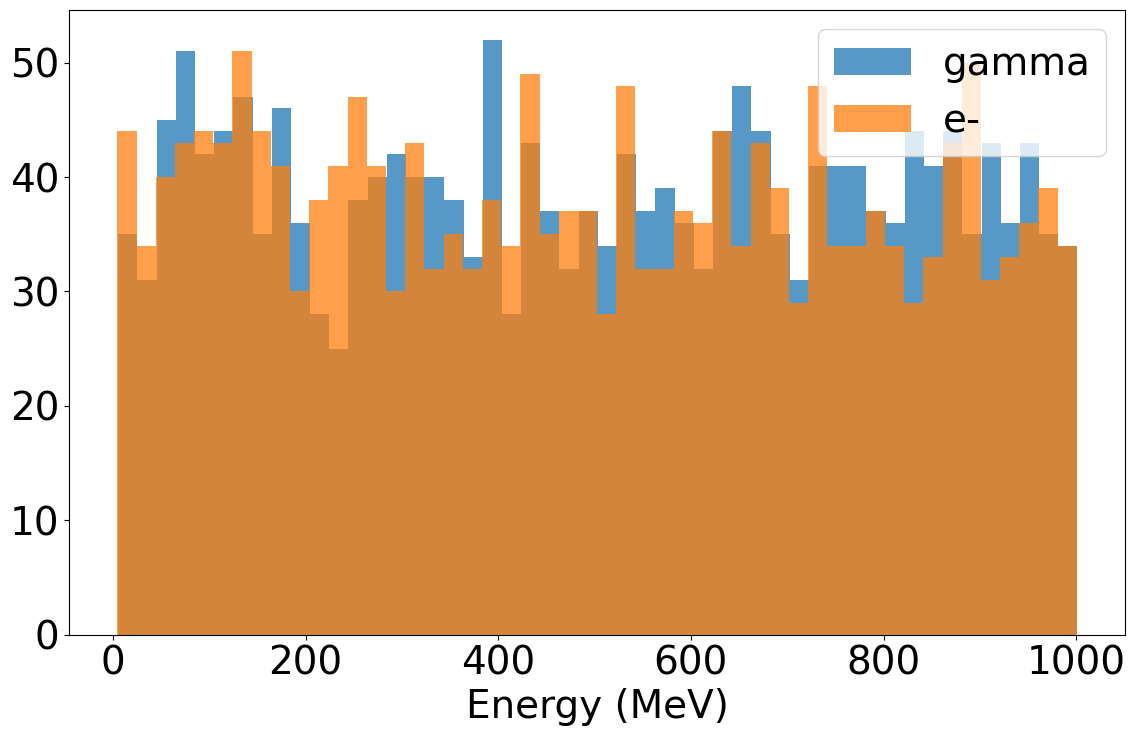

In [17]:
en_gamma = h5_energies[h5_gammas]
en_elec = h5_energies[h5_electrons]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(12.0)

plt.hist(en_gamma,bins=50,label='gamma',alpha=0.75)
plt.hist(en_elec,bins=50,label='e-',alpha=0.75)
plt.xlabel("Energy (MeV)")
plt.legend()

### towall

Text(0.5, 0, 'dwall (cm)')

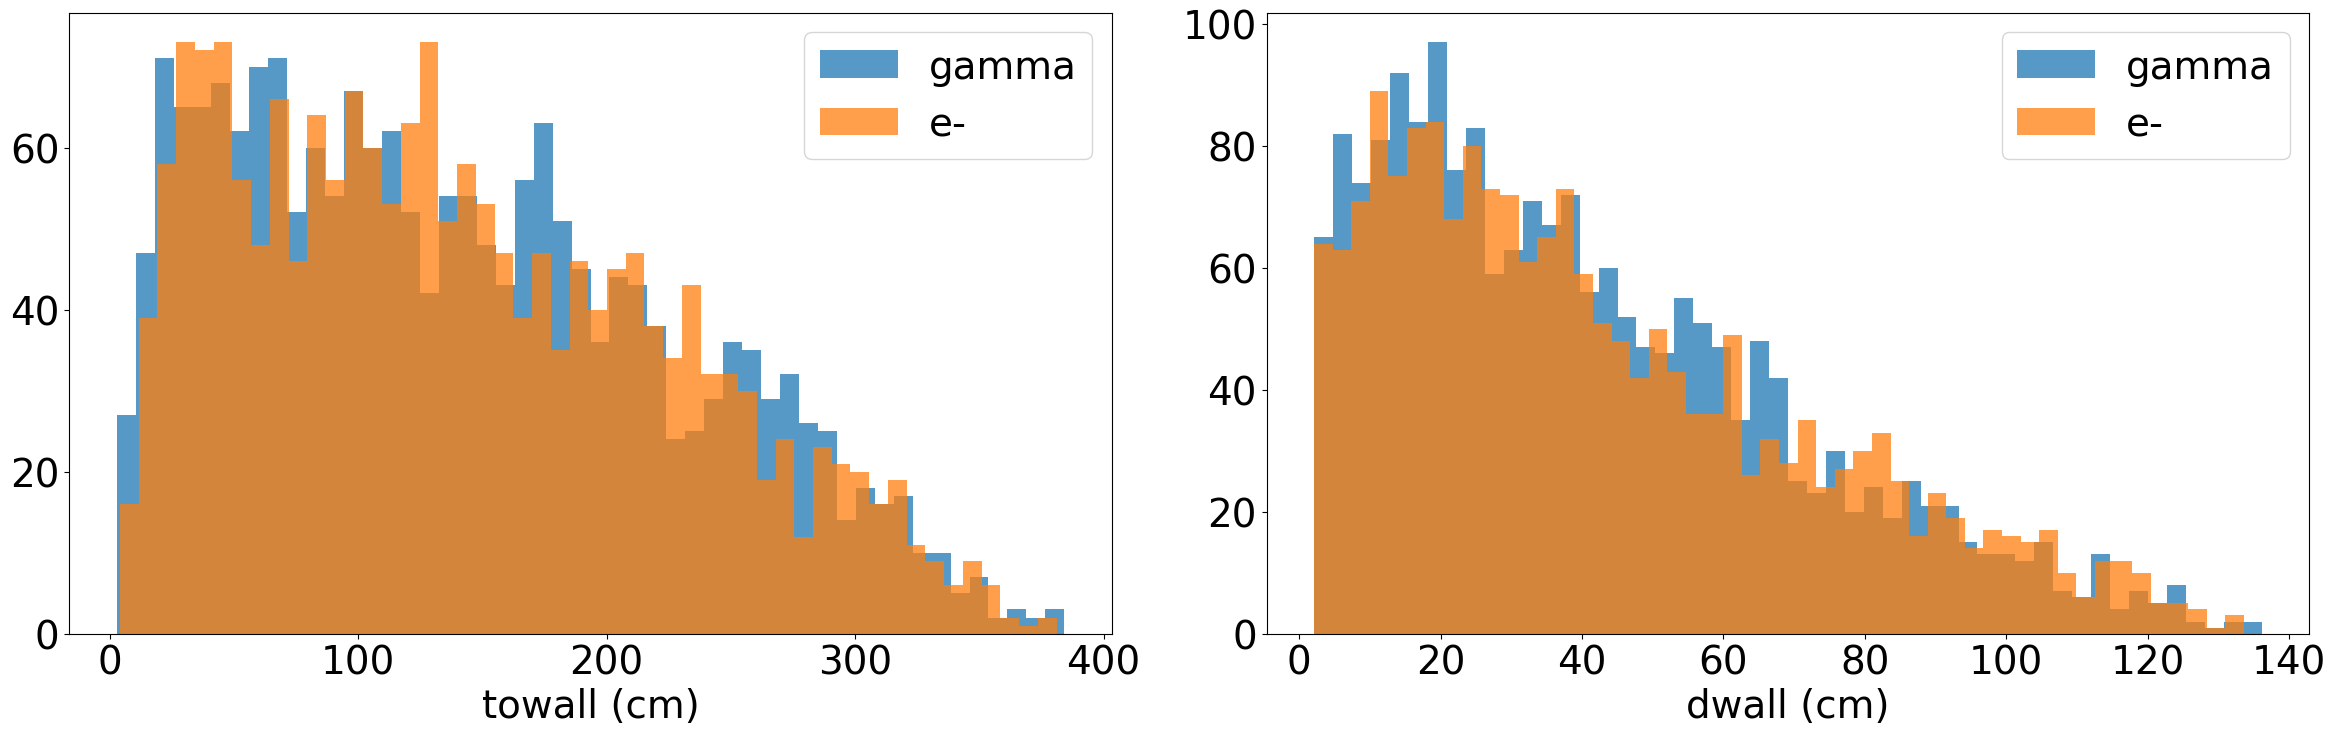

In [18]:
towall_gamma = h5_towall[(h5_gammas & cuts)]
towall_elec = h5_towall[(h5_electrons & cuts)]
dwall_gamma = h5_dwall[(h5_gammas & cuts)]
dwall_elec = h5_dwall[(h5_electrons & cuts)]

fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(121)
ax1.hist(towall_gamma,bins=50,label='gamma',alpha=0.75)
ax1.hist(towall_elec,bins=50,label='e-',alpha=0.75)
ax1.legend()
ax1.set_xlabel("towall (cm)")
ax2 = fig.add_subplot(122)
ax2.hist(dwall_gamma,bins=50,label='gamma',alpha=0.75)
ax2.hist(dwall_elec,bins=50,label='e-',alpha=0.75)
ax2.legend()
ax2.set_xlabel("dwall (cm)")

# Hit charge and time information

In [19]:
df_gamma_hits    = df_hits[df_hits.label == 0]
df_electron_hits = df_hits[df_hits.label == 1]

charge_gamma     = df_gamma_hits['charge']
time_gamma    = df_gamma_hits['time']

charge_electron  = df_electron_hits['charge']
time_electron = df_electron_hits['time']

Text(0, 0.5, 'counts/bin')

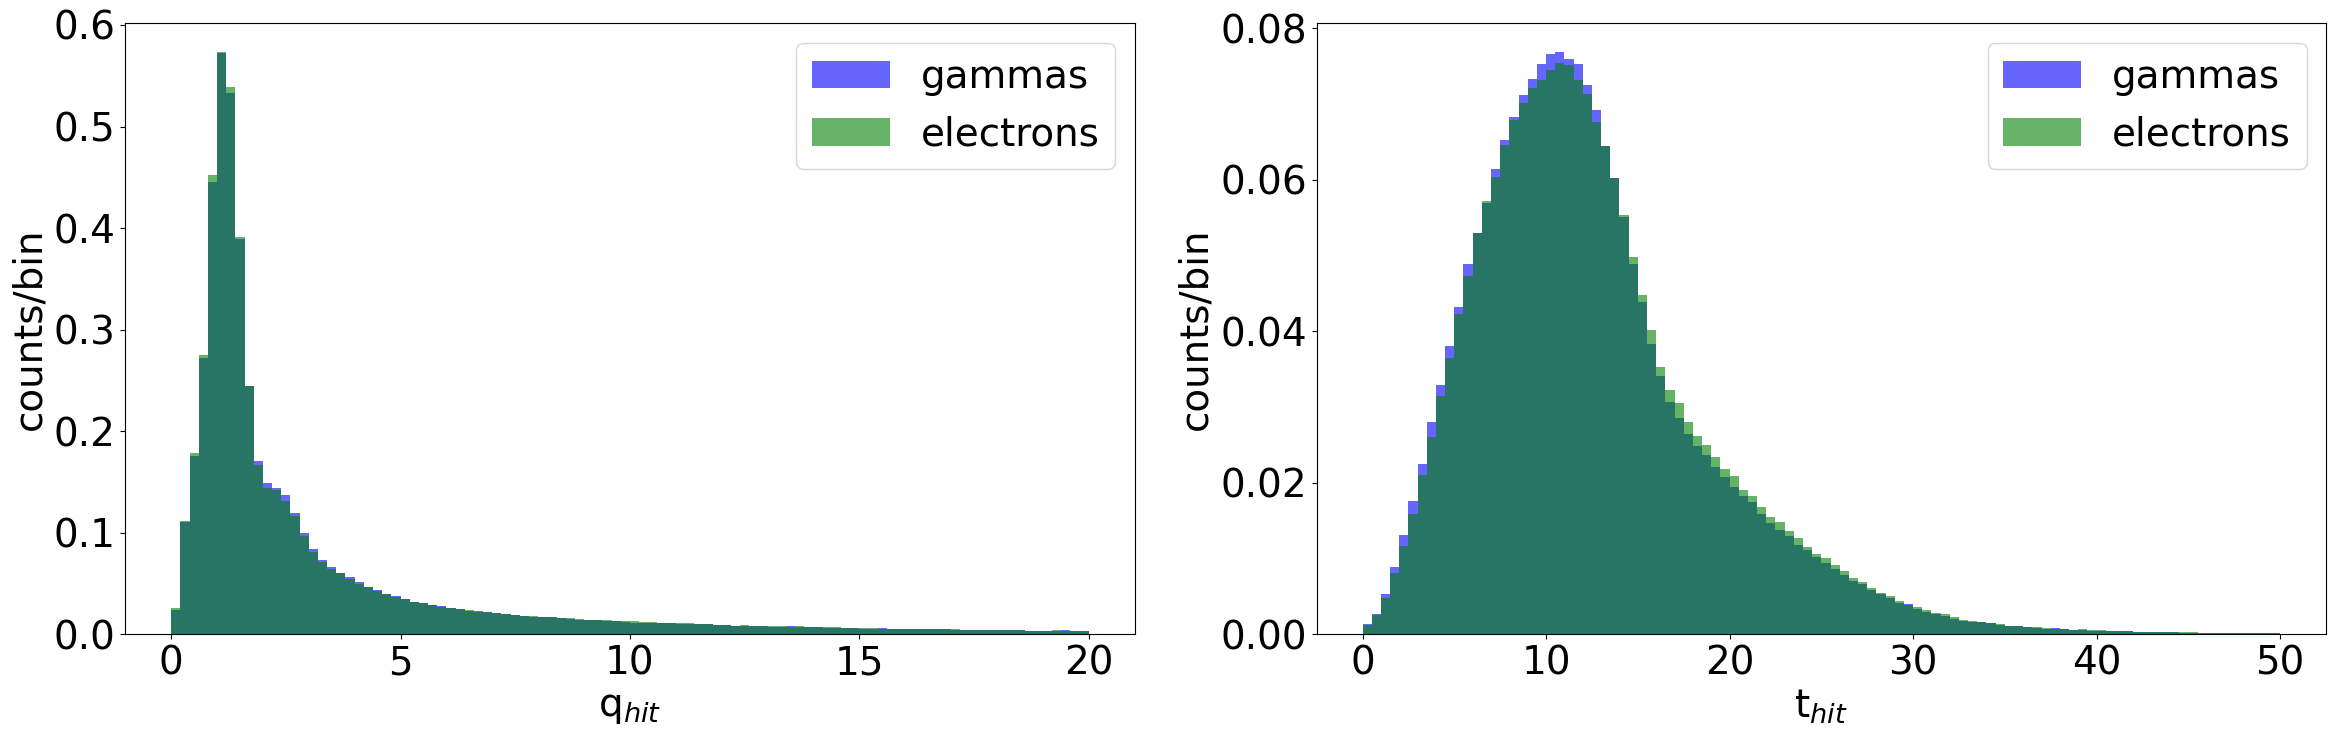

In [20]:
fig = plt.figure()
fig.set_figheight(8.0)
fig.set_figwidth(24.0)

ax1 = fig.add_subplot(121)
ax1.hist(charge_gamma,bins=100,color='blue',label='gammas',alpha=0.6,range=[0,20],density=True)
ax1.hist(charge_electron,bins=100,color='green',label='electrons',alpha=0.6,range=[0,20],density=True)
#ax1.set_yscale('log')
ax1.legend()
#ax1.set_xlabel("log$_{10}$(q$_{hit}$)")
ax1.set_xlabel("q$_{hit}$")
ax1.set_ylabel("counts/bin")
ax2 = fig.add_subplot(122)
ax2.hist(time_gamma,bins=100,color='blue',label='gammas',alpha=0.6,range=[0,50],density=True)
ax2.hist(time_electron,bins=100,color='green',label='electrons',alpha=0.6,range=[0,50],density=True)
#ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel("t$_{hit}$")
ax2.set_ylabel("counts/bin")

## Bin events in various quantities

Here we use the binning functions that allow us to bin events by various quantities:

In [21]:
help(get_binning)

Help on function get_binning in module analysis.utils.binning:

get_binning(x, bins=None, minimum=None, maximum=None, width=None)
    Finds the indices of the bins to which each value in input array belongs, for a set of bins specified either as an
    array of bin edges, number of bins or bin width
    
    Parameters
    ----------
    x: array_like
        Input array to be binned.
    bins: array_like, optional
        If `bins` is an int, it defines the number of equal-width bins in the range (200, by default). If `bins` is an
        array, it is the array of bin edges and must be 1-dimensional and monotonic.
    minimum: int or real, optional
        Lowest bin lower edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    maximum: int or real, optional
        Highest bin upper edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    width: int or real, optional
        Width of bins to generate equal w

In [22]:
mom_binning = get_binning(h5_momentum, 17, 150, 1000)
cos_zenith_binning = get_binning(np.cos(h5_angles[:,0]), 20, -1, 1)
azimuth_binning = get_binning(h5_angles[:,1]*180/np.pi, 20, -180, 180)
dwall_binning = get_binning(h5_dwall, 22, 50, 300)
towall_binning = get_binning(h5_towall, 30, 50, 800)

# Electron / gamma

## Load results
### Load ResNet and fiTQun results

Here we set up an instance of the classification class for WatChMaL outputs:

In [23]:
help(WatChMaLClassification)

Help on class WatChMaLClassification in module analysis.classification:

class WatChMaLClassification(ClassificationRun, analysis.read.WatChMaLOutput)
 |  WatChMaLClassification(directory, run_label, true_labels=None, indices=None, selection=None, **plot_args)
 |  
 |  Class to hold results of a WatChMaL classification run
 |  
 |  Method resolution order:
 |      WatChMaLClassification
 |      ClassificationRun
 |      analysis.read.WatChMaLOutput
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, directory, run_label, true_labels=None, indices=None, selection=None, **plot_args)
 |      Constructs the object holding the results of a WatChMaL classification run.
 |      
 |      Parameters
 |      ----------
 |      directory: str
 |          Top-level output directory of a WatChMaL classification run.
 |      run_label: str
 |          Label to describe this set of results to use in plot legends, etc.
 |      true_labels: array_like of int, 

In [24]:
resnet_run_gammaconv             = WatChMaLClassification("21-05-33", "ResNet_WCTE_3class", h5_labels, test_idxs, cuts, color="red", linestyle='-')
resnet_run_gammaconv_time        = WatChMaLClassification("18-20-31", "ResNet_WCTE_3class_with_time", h5_labels, test_idxs, cuts, color="green", linestyle='-')
resnet_run_gammaconv_time_2class = WatChMaLClassification("17-45-07", "ResNet_WCTE_2class_with_time", h5_labels, test_idxs, cuts, color="blue", linestyle='-')
resnet_run_IWCD_4class           = WatChMaLClassification("2022-06-28/09-06-55", "ResNet_IWCD_4class 2022-06-28/09-06-55", test_iwcd_4class_labels, test_iwcd_4class_idxs, color="brown", linestyle='--')
resnet_run_IWCD_2class           = WatChMaLClassification("2022-07-06/07-47-10", "ResNet_IWCD_2class 2022-07-06/07-47-10", test_iwcd_2class_labels, test_iwcd_2class_idxs, color="orange", linestyle='--')

### Plot training progression

In [25]:
help(WatChMaLClassification.plot_training_progression)

Help on function plot_training_progression in module analysis.classification:

plot_training_progression(self, plot_best=True, y_loss_lim=None, fig_size=None, title=None, legend='center right')
    Plot the progression of training and validation loss and accuracy from the run's logs
    
    Parameters
    ----------
    plot_best: bool, optional
        If true (default), plot points indicating the best validation loss and accuracy
    y_loss_lim: (int, int), optional
        Range for the loss y-axis. By default, the range will expand to show all loss values in the logs.
    fig_size: (float, float), optional
        Size of the figure
    title: str, optional
        Title of the figure. By default, do not plot a title.
    legend: str, optional
        Position to plot the legend. By default, the legend is placed in the center right. For no legend use `None`.
    
    Returns
    -------
    matplotlib.figure.Figure
    matplotlib.axes.Axes



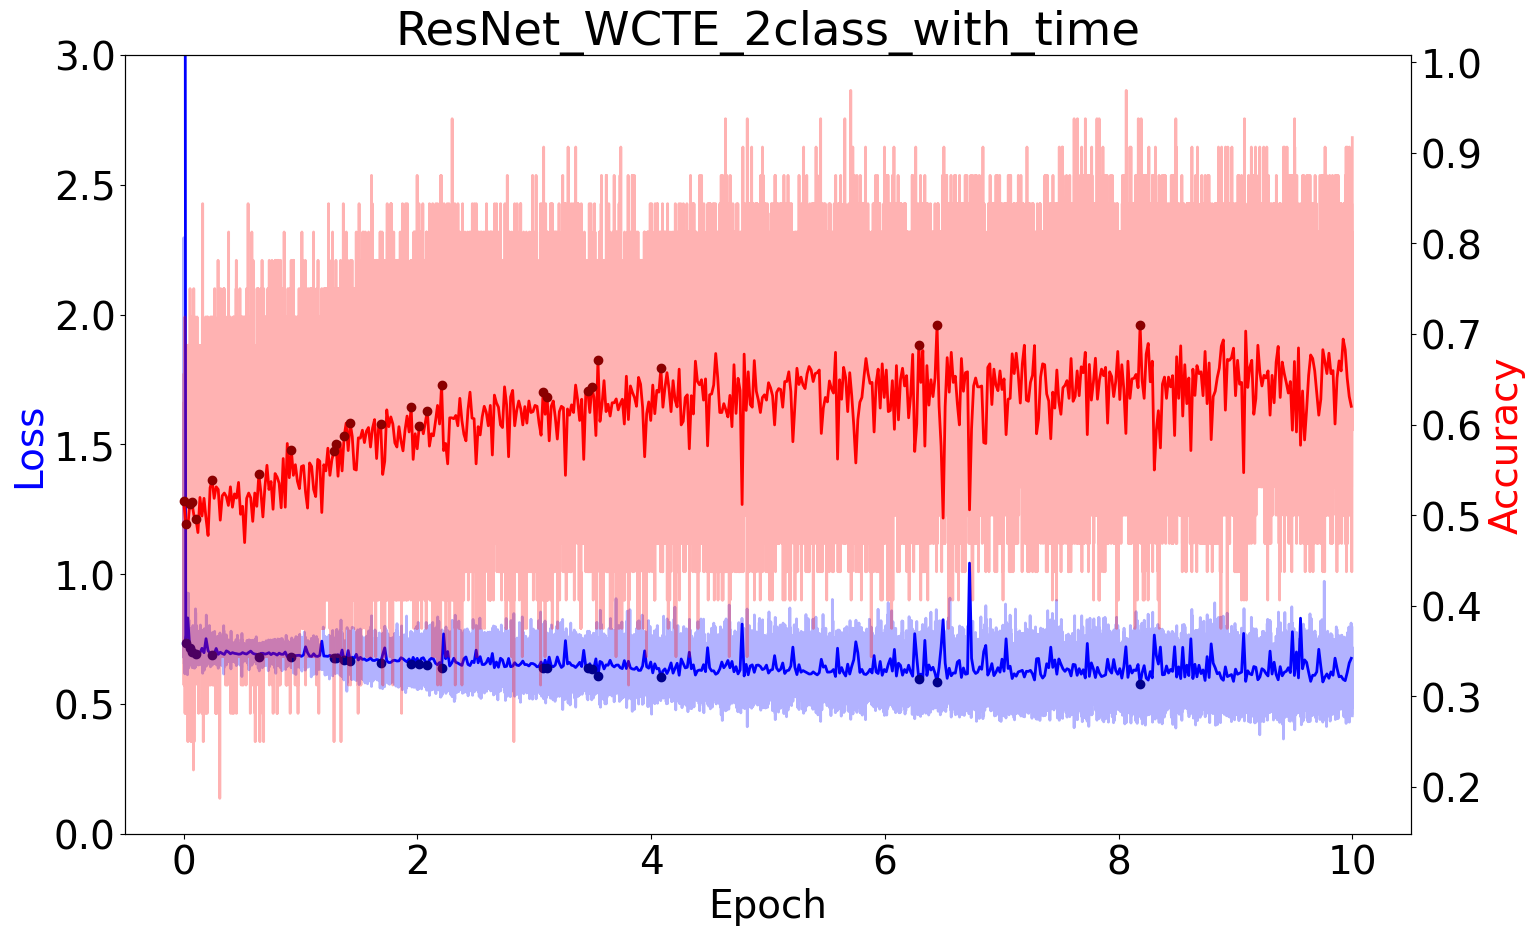

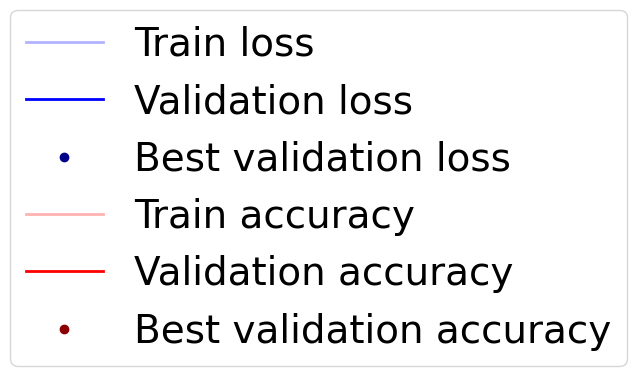

In [26]:
fig, ax1, ax2, = resnet_run_gammaconv_time_2class.plot_training_progression(legend=None, fig_size=(16,10), title=resnet_run_gammaconv_time_2class.run_label, y_loss_lim=(0,3))
leg_fig, leg_ax = plot_legend((ax1, ax2))

## Plot results

### Plot histograms of the predicted probabilities
For electron vs muon probabilities, in a 4-class model with gammas (which are also considered electron-like) we need to combine the electron and gamma softmaxes to get the electron-like probability.
The discriminator method used below automatically calulates the signal probability from the softmax values of the given signal and background labels.

In [27]:
help(WatChMaLClassification.discriminator)

Help on function discriminator in module analysis.classification:

discriminator(self, signal_labels, background_labels)
    Return a discriminator with appropriate scaling of softmax values from multi-class training, given the set of
    signal and background class labels. For each event, the discriminator is the sum the signal softmax values
    normalised by the sum of signal and background softmax values.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels corresponding to signal classes. Can be either a single label or a sequence of labels.
    background_labels: int or sequence of ints
        Set of labels corresponding to background classes. Can be either a single label or a sequence of labels.
    
    Returns
    -------
    np.ndarray
        One-dimensional array of discriminator values, with length equal to the number of events in this run.



In [28]:
# 0 --> gamma (ID 22)
# 1 --> electron (ID 11)
# 2 --> muon (ID 13)
gamma_labels = [0]
e_labels = [1]

type1_labels = [1]
type2_labels = [0]

type1 = "electron"
type2 = "gamma"

# e vs. gamma
type1_probabilities = resnet_run_gammaconv_time_2class.discriminator(type1_labels, type2_labels)
type2_probabilities = resnet_run_gammaconv_time_2class.discriminator(type2_labels, type1_labels)

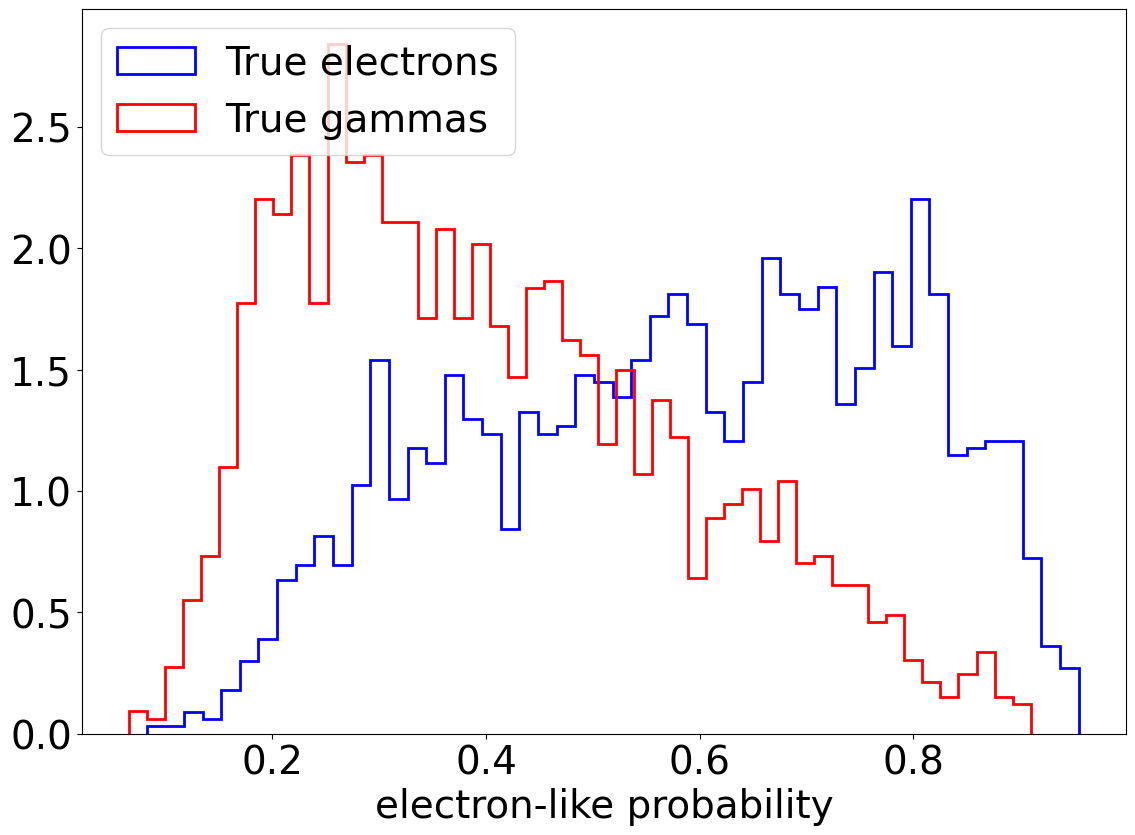

In [29]:
fig, ax = plt.subplots()
ax.hist(type1_probabilities[(h5_electrons)], density=True, histtype='step', lw=2, color='blue', bins=50, label='True electrons')
ax.hist(type1_probabilities[h5_gammas], density=True, histtype='step', lw=2, color='red', bins=50, label='True gammas')
ax.set_xlabel("{}-like probability".format(type1))
ax.legend(loc=2)

### ROC curve for electron signal vs gamma rejection

The `plot_rocs` function allows plotting overlaid ROC curves for a chosen signal and background classification.

In [30]:
help(plot_rocs)

Help on function plot_rocs in module analysis.classification:

plot_rocs(runs, signal_labels, background_labels, selection=None, ax=None, fig_size=None, x_label='', y_label='', x_lim=None, y_lim=None, y_log=None, x_log=None, legend='best', mode='rejection', **plot_args)
    Plot overlaid ROC curves of results from a number of classification runs
    
    Parameters
    ----------
    runs: sequence of ClassificationRun
        Sequence of runs to plot
    signal_labels: int or sequence of ints
        Set of labels corresponding to signal classes. Can be either a single label or a sequence of labels.
    background_labels: int or sequence of ints
        Set of labels corresponding to background classes. Can be either a single label or a sequence of labels.
    selection: indexing expression, optional
        Selection of the discriminator values to be used (by default use each run's predefined selection, or all events
        if none is defined).
    ax: matplotlib.axes.Axes
        A

We plot using a few different formats for viewing the ROC data.

Note that in several of the plotting functions, we pass a list of runs (here just containing a single run, i.e. `[resnet_run]`). To make plots comparing multiple classification runs, for example with different network architectures or hyperparameters, you can simply replace this with a list containing more than one run.

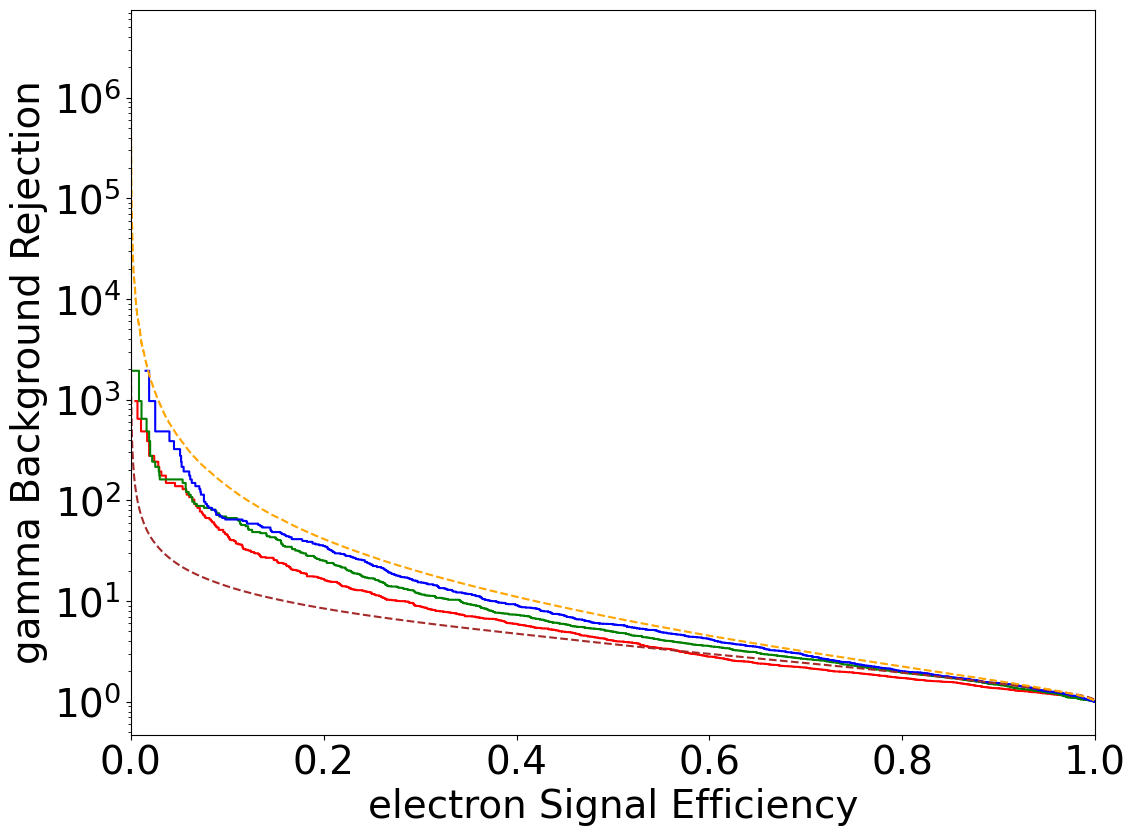

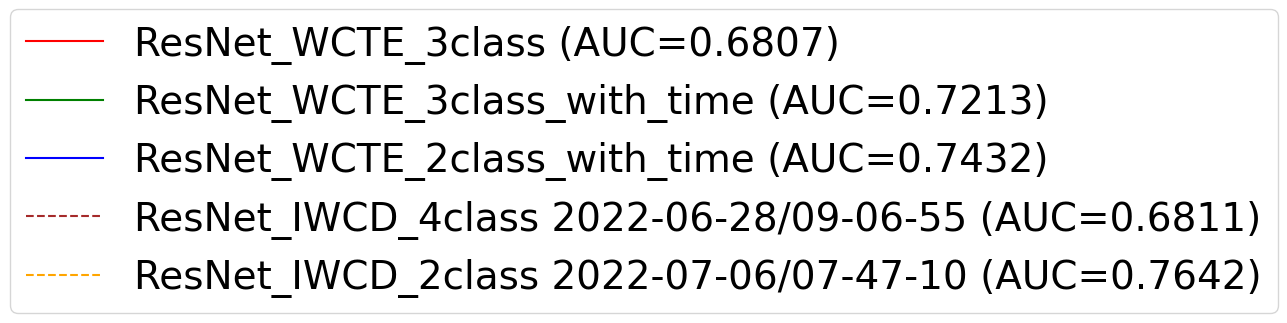

In [31]:
#fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Signal Efficiency".format(type1), y_label="{} Background Rejection".format(type2), mode='rejection', legend=None)
fig, ax = plot_rocs([resnet_run_gammaconv, resnet_run_gammaconv_time, resnet_run_gammaconv_time_2class, resnet_run_IWCD_4class, resnet_run_IWCD_2class], type1_labels, type2_labels, x_label="{} Signal Efficiency".format(type1), y_label="{} Background Rejection".format(type2), mode='rejection', x_lim=(0.0,1), legend=None)
#fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Background Mis-ID rate".format(type2), y_label="{} Signal Efficiency".format(type1), mode='efficiency', x_lim=(0,1.0), legend=None)
#fig, ax = plot_rocs([resnet_run], type1_labels, type2_labels, x_label="{} Background Mis-ID rate".format(type2), y_label="{} Signal Efficiency".format(type1), mode='efficiency', x_log=True, legend=None)
l_fig, l_ax = plot_legend(ax)

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds that reject the specified fraction of gammas and apply cut to all events

In [32]:
help(WatChMaLClassification.cut_with_fixed_efficiency)

Help on function cut_with_fixed_efficiency in module analysis.classification:

cut_with_fixed_efficiency(self, signal_labels, background_labels, efficiency, selection=None, select_labels=None, return_threshold=False)
    Generate array of boolean values indicating whether each event passes a cut defined such that a fixed proportion
    of the selected events pass the cut.
    After taking the subset of `discriminator_values` defined by `selection`, the threshold discriminator value is
    found such that the proportion that are above the threshold is equal to `efficiency`. This cut threshold is then
    used to apply the cut to all events (not just those selected by `selection`) and an array of booleans is
    returned for whether each discriminator value is above the threshold of its corresponding bin. The cut result is
    also stored for use in plotting efficiency profiles.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels correspond

In [34]:
type2_rejection = 0.75
type2_efficiency = 1-type2_rejection
resnet_run_gammaconv_time_2class.cut_with_fixed_efficiency(type1_labels, type2_labels, type2_efficiency, select_labels=type2_labels)

array([False,  True, False, ...,  True,  True,  True])

### Plot signal efficiency against true momentum, dwall, towall, zenith, azimuth

In [35]:
help(plot_efficiency_profile)

Help on function plot_efficiency_profile in module analysis.classification:

plot_efficiency_profile(runs, binning, selection=None, select_labels=None, ax=None, fig_size=None, x_label='', y_label='', legend='best', y_lim=None, **plot_args)
    Plot binned efficiencies for a cut applied to a number of classification runs.
    Each run should already have had a cut generated, then in each bin the proportion of events passing the cut is
    calculated as the efficiency and plotted. A selection can be provided to use only a subset of all the values. The
    same binning and selection is applied to each run.
    
    Parameters
    ----------
    runs: sequence of ClassificationRun
        Sequence of runs to plot
    binning: (np.ndarray, np.ndarray)
        Array of bin edges and array of bin indices, returned from `analysis.utils.binning.get_binning`.
    selection: indexing expression, optional
        Selection of the values to use in calculating the efficiencies (by default use each r

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


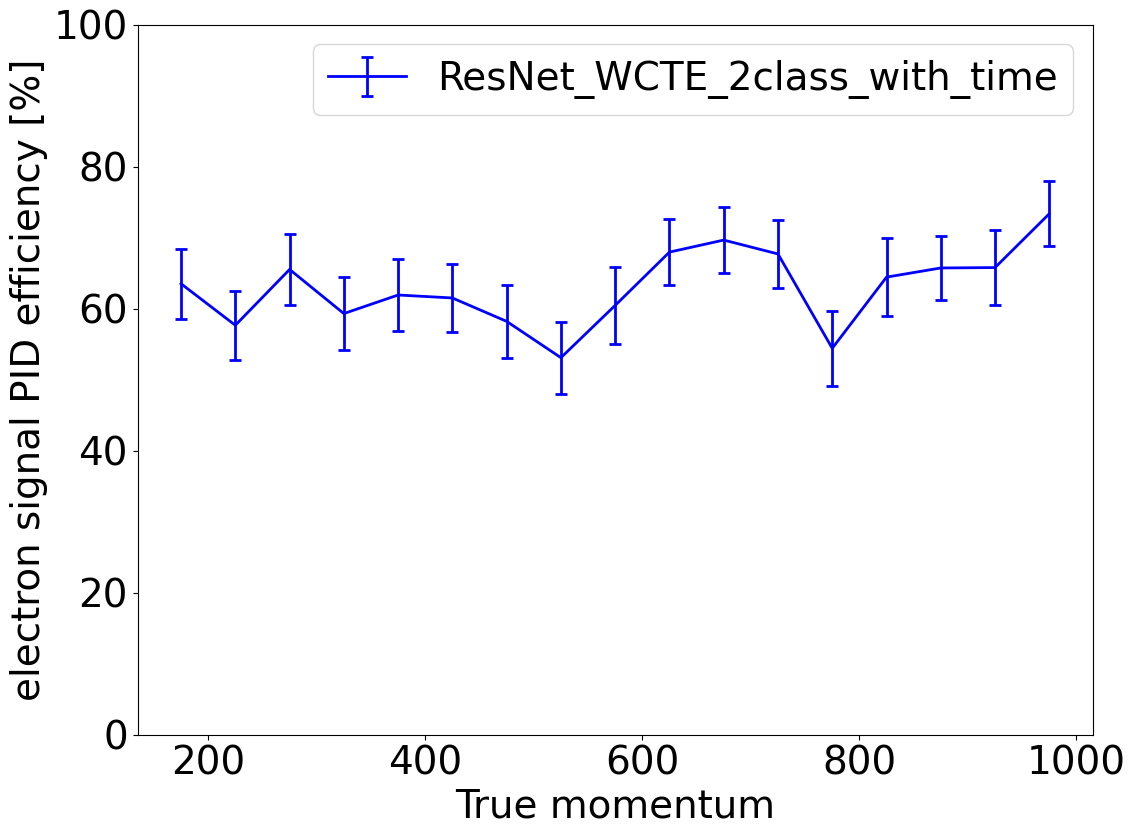

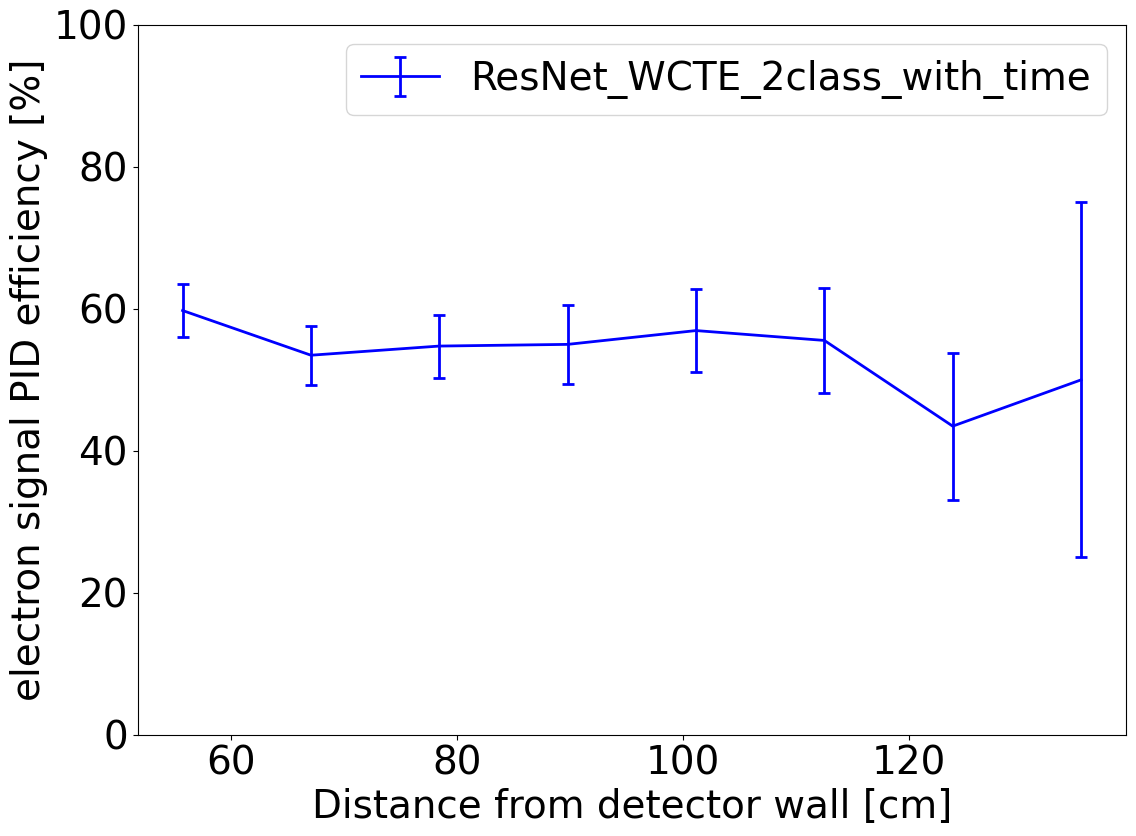

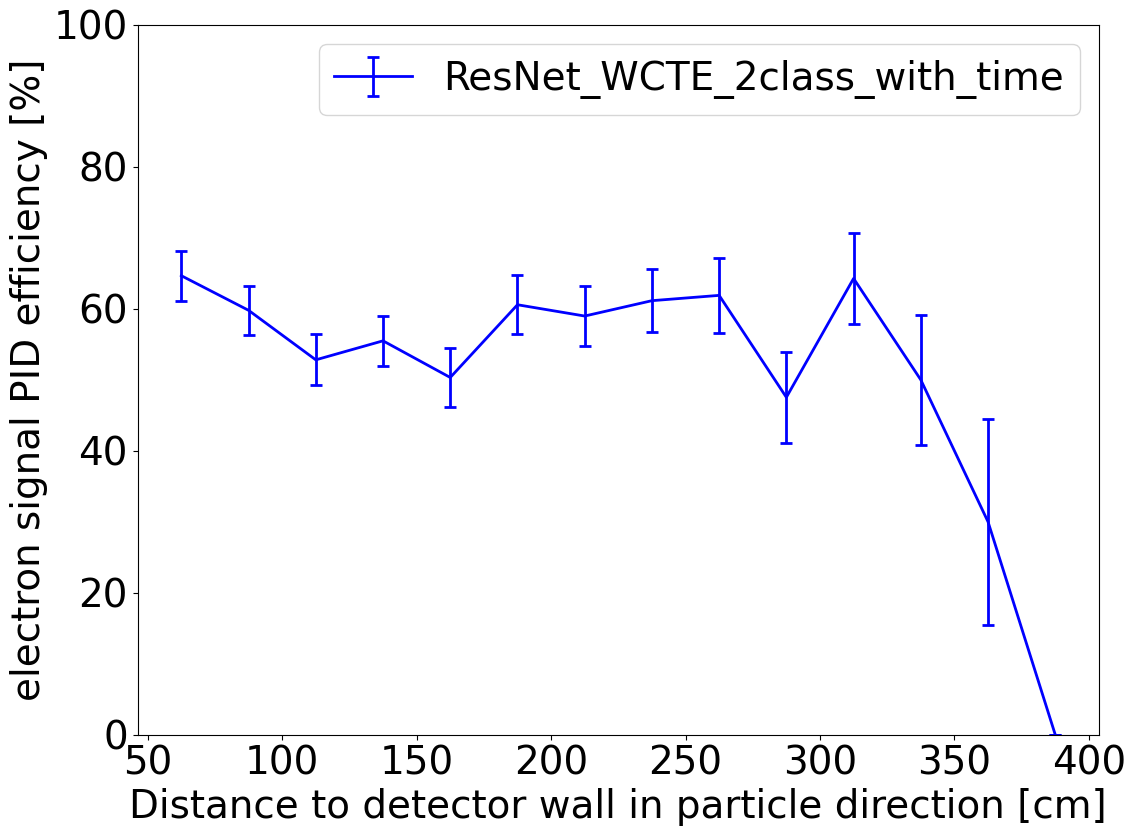

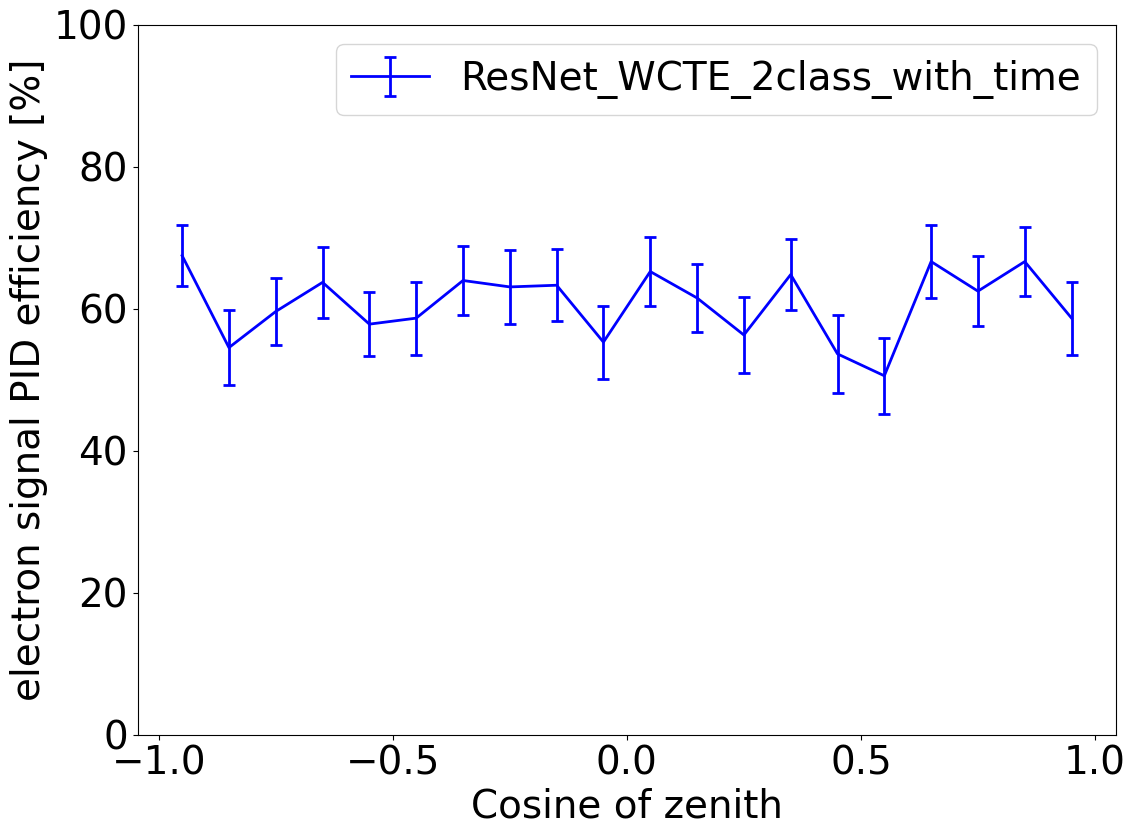

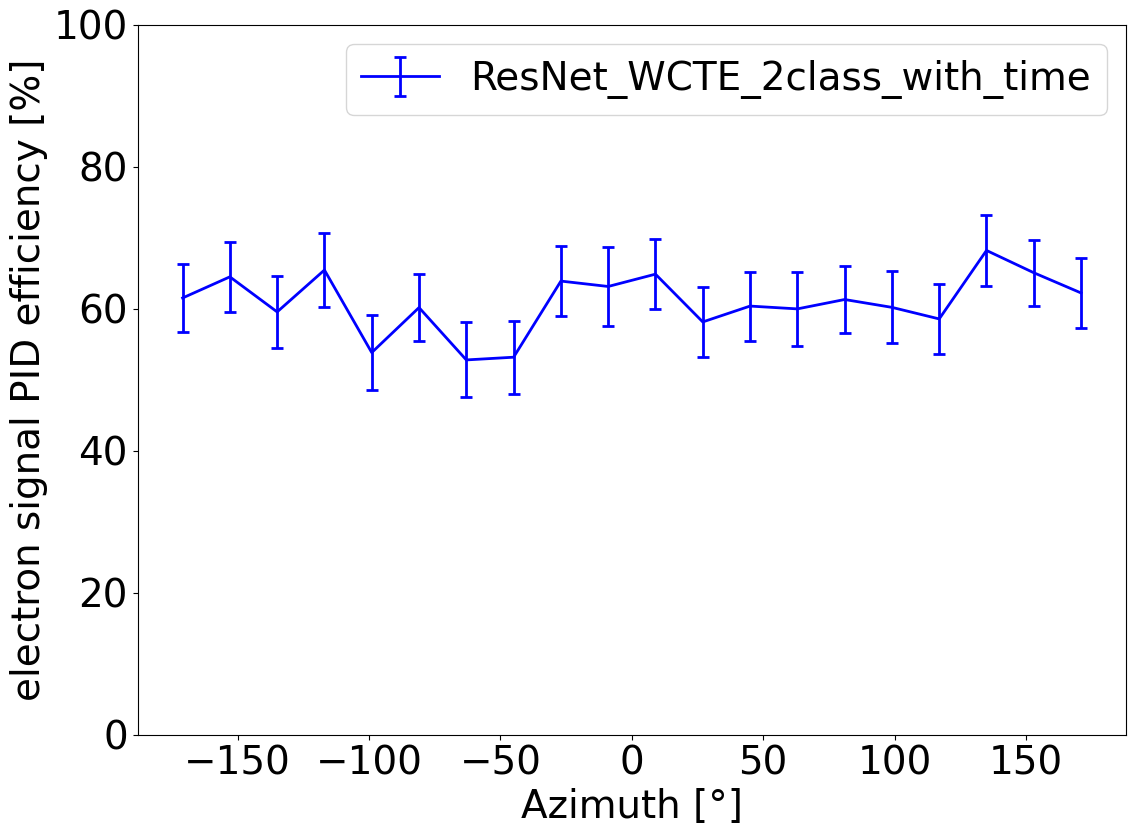

In [38]:
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], mom_binning, select_labels=type1_labels, x_label="True momentum", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], dwall_binning, select_labels=type1_labels, x_label="Distance from detector wall [cm]", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], towall_binning, select_labels=type1_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], cos_zenith_binning, select_labels=type1_labels, x_label="Cosine of zenith", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], azimuth_binning, select_labels=type1_labels, x_label="Azimuth [°]", y_label="{} signal PID efficiency [%]".format(type1), errors=True, x_errors=False, y_lim=(0,100))

### Plot background mis-ID against true momentum, dwall, towall, zenith, azimuth

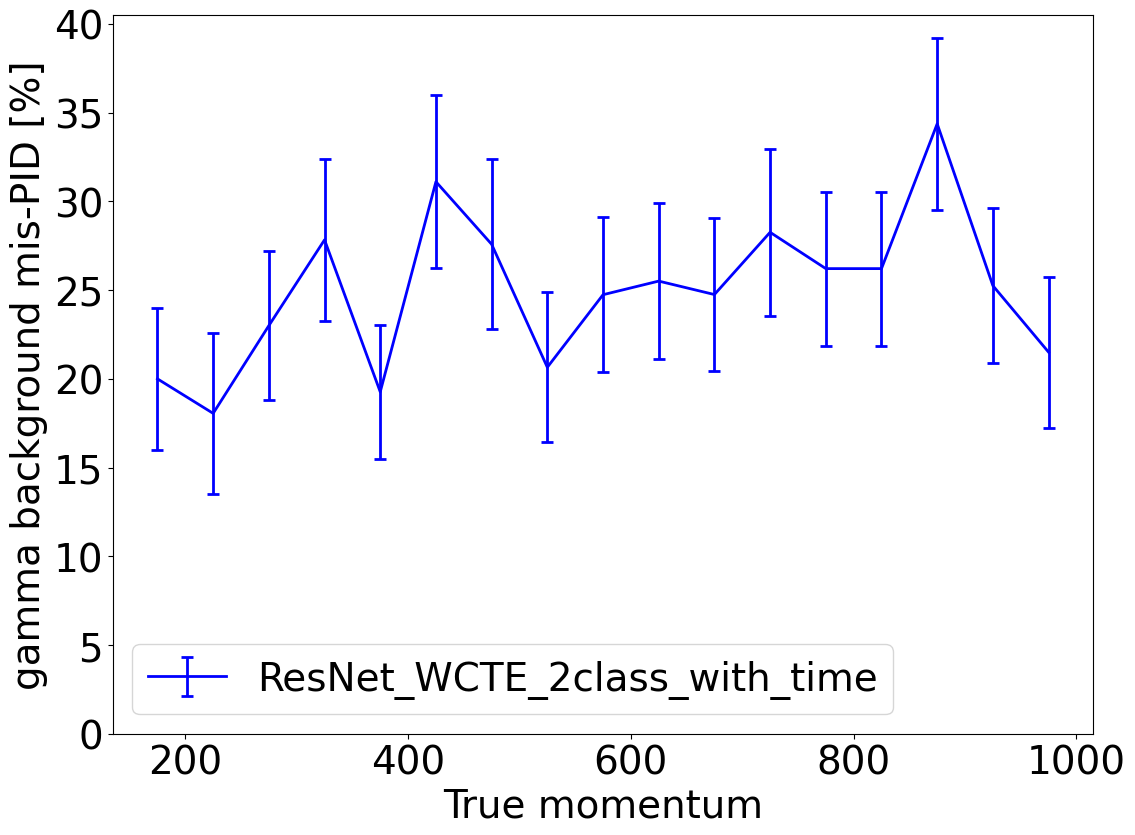

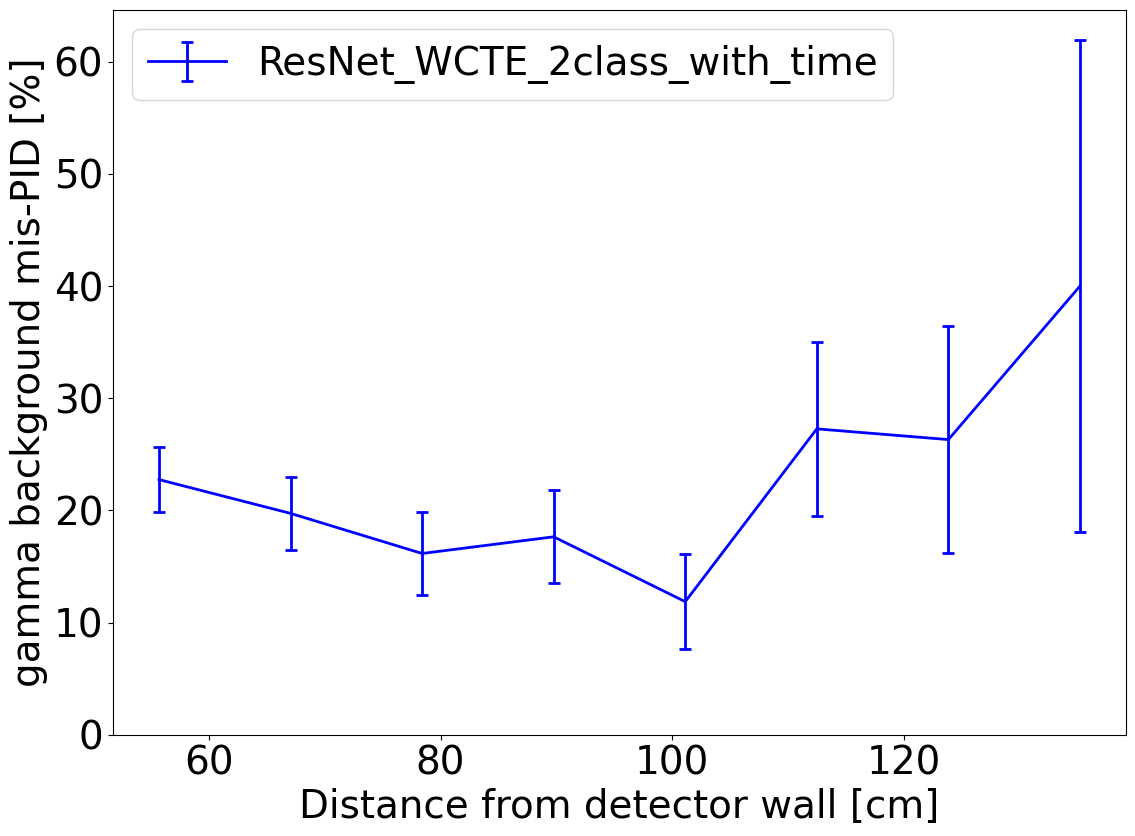

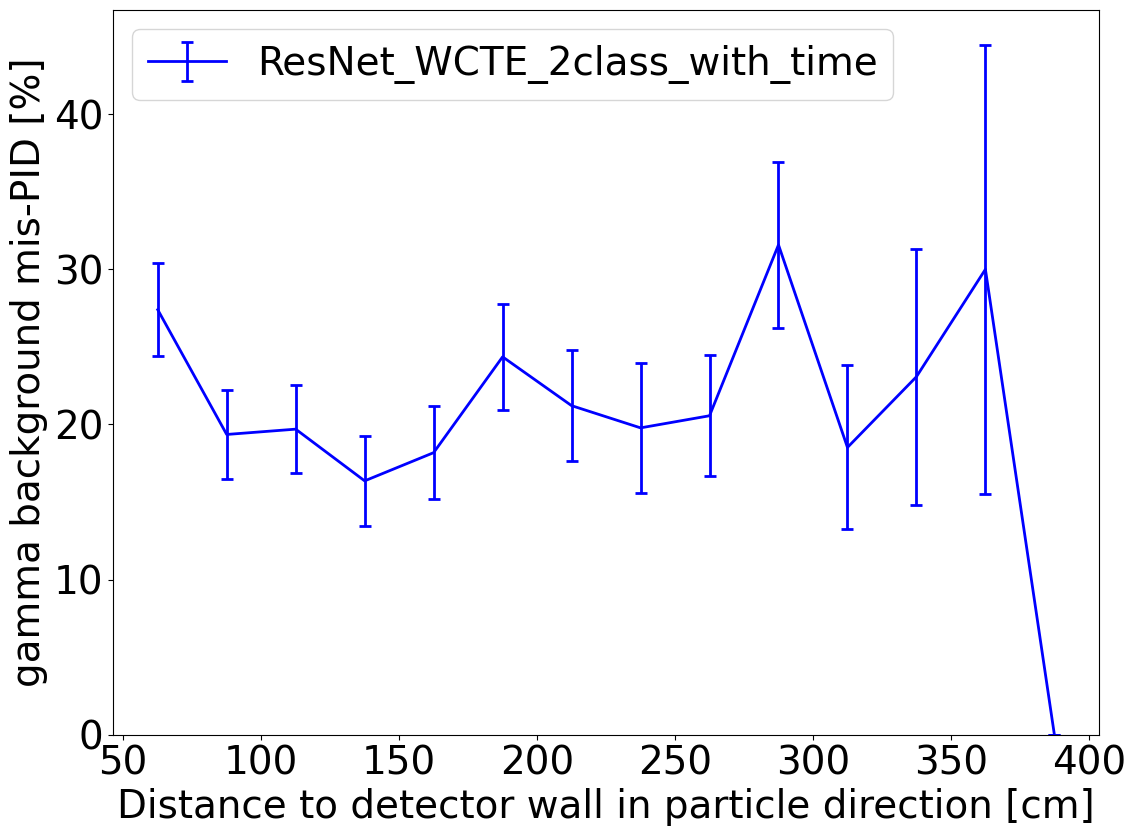

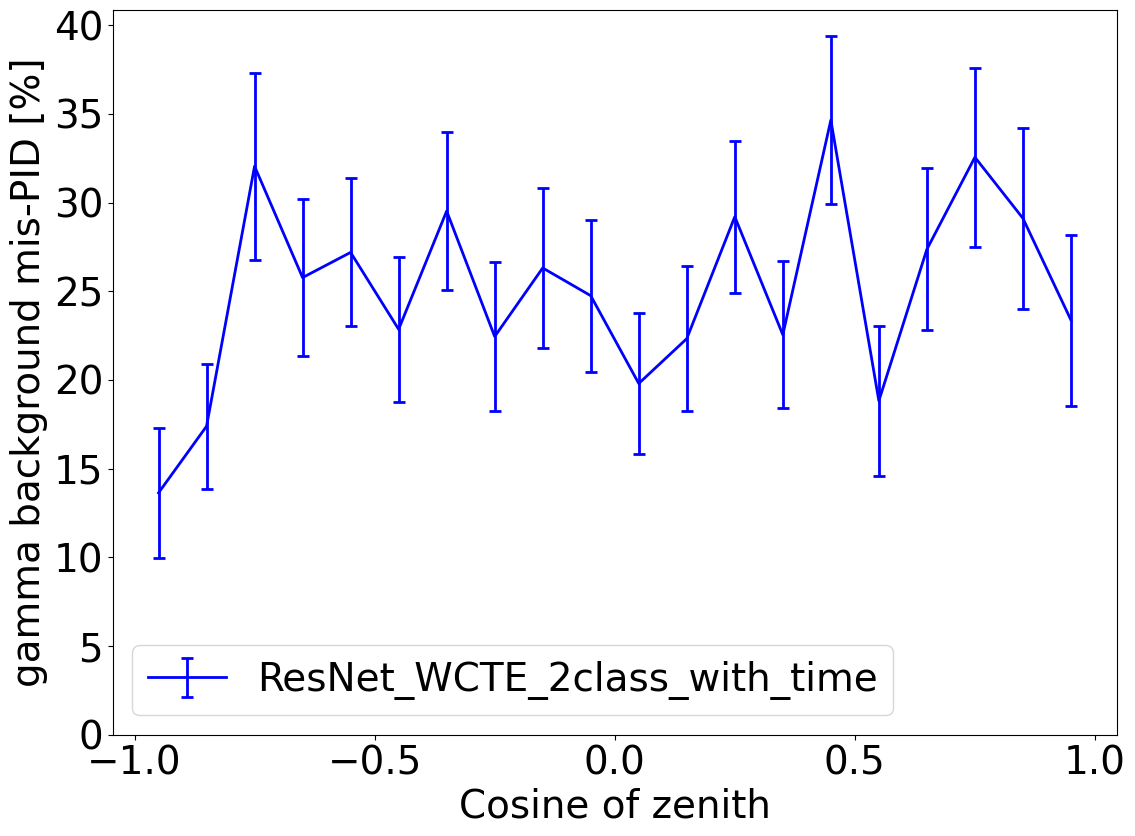

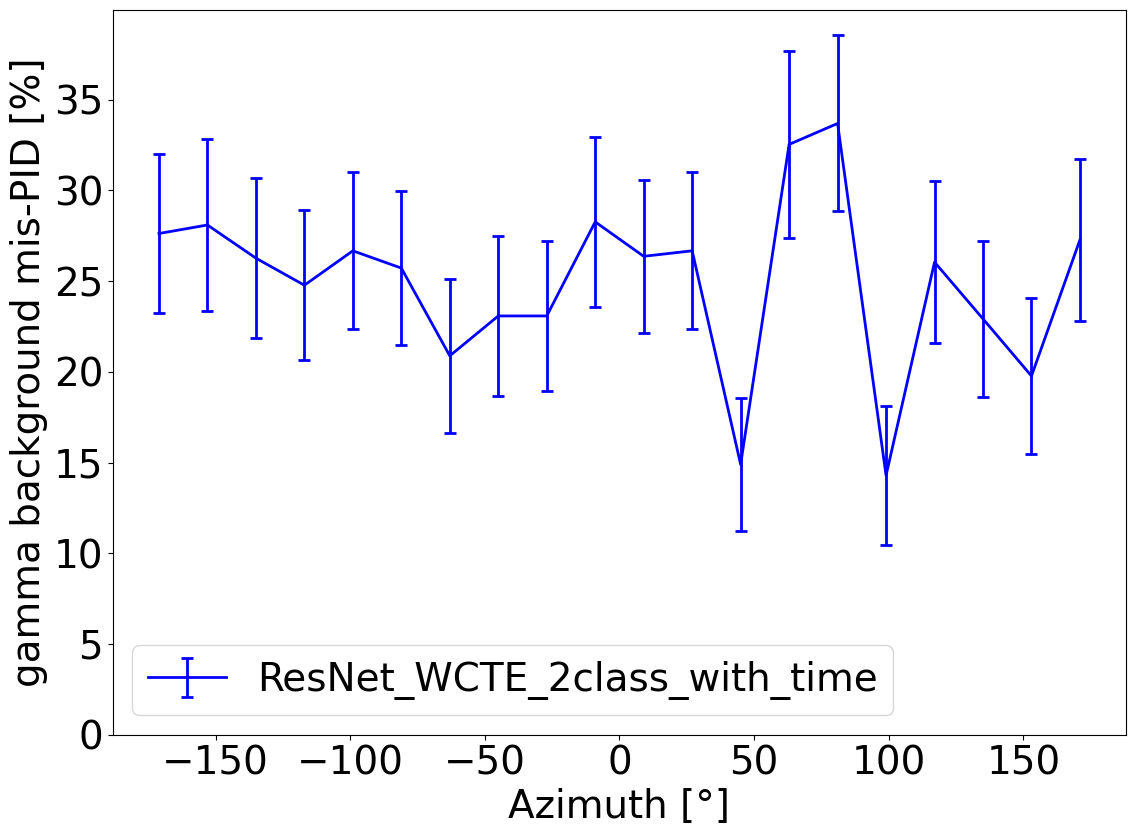

In [40]:
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], mom_binning, select_labels=type2_labels, x_label="True momentum", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], dwall_binning, select_labels=type2_labels, x_label="Distance from detector wall [cm]", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], towall_binning, select_labels=type2_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], cos_zenith_binning, select_labels=type2_labels, x_label="Cosine of zenith", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run_gammaconv_time_2class], azimuth_binning, select_labels=type2_labels, x_label="Azimuth [°]", y_label="{} background mis-PID [%]".format(type2), errors=True, x_errors=False, y_lim=0)

# Plot individual events (not ready for use yet)

In [ ]:
# import os
# import torch
# os.environ['TORCH'] = torch.__version__
# print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#dataset_wcte = CNNmPMTDataset(h5file="mu_e_gamma.h5", mpmt_positions_file="NuPRISMBeamTest_16cShort_mPMT_positions.npz")